In [16]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import scipy as sp
import pywt # wavelet transforms
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

IMG_FOLDER = Path('./report/src/img/')
IMG_FOLDER.mkdir(parents=True, exist_ok=True)

In [21]:
# read Q{1,2,3}.mat
q1 = sp.io.loadmat('./data/Q1.mat')
Fs = 8192 # sampling frequency in Hz
q2 = sp.io.loadmat('./data/Q2.mat')
q3 = sp.io.loadmat('./data/Q3.mat')

In [3]:
print(q1.keys())
print(q2.keys())
print(q3.keys())

dict_keys(['__header__', '__version__', '__globals__', 'y'])
dict_keys(['__header__', '__version__', '__globals__', 'EEG'])
dict_keys(['__header__', '__version__', '__globals__', 'noisy_EEG'])


In [19]:
y = q1['y']
y = y.squeeze()
print(y.shape)
EEG = q2['EEG']
noisy_EEG = q3['noisy_EEG']

(73113,)


In [5]:
print('type(y):', type(y))
print('type(EEG):', type(EEG))
print('type(noisy_EEG):', type(noisy_EEG))
print('y.shape:', y.shape)
print('EEG.shape:', EEG.shape)
print('noisy_EEG.shape:', noisy_EEG.shape)

type(y): <class 'numpy.ndarray'>
type(EEG): <class 'numpy.ndarray'>
type(noisy_EEG): <class 'numpy.ndarray'>
y.shape: (73113, 1)
EEG.shape: (2500, 1)
noisy_EEG.shape: (2500, 1)


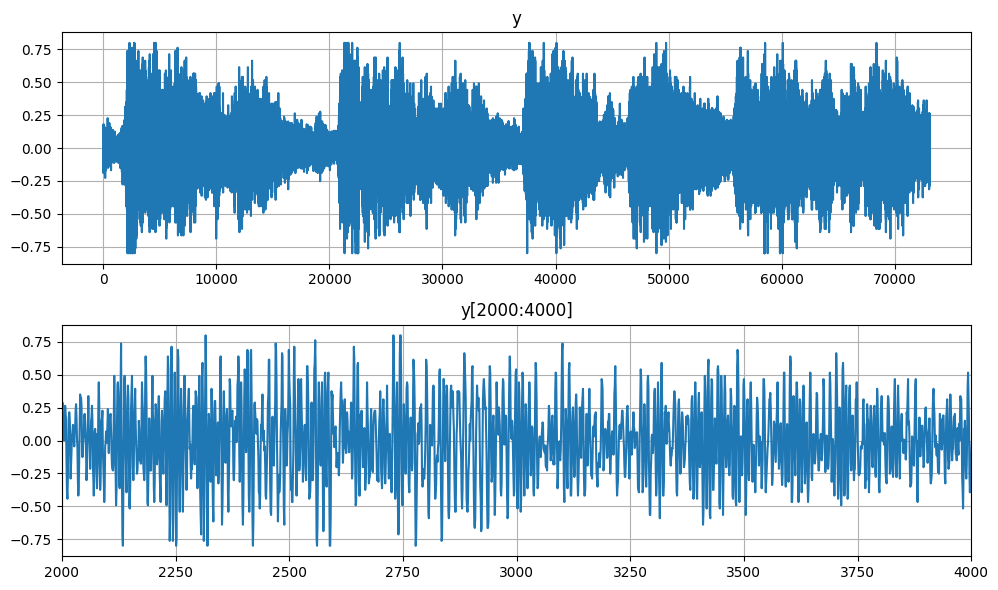

In [6]:
# plot Q1.mat data
_, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(y)
axs[0].set_title('y')
axs[0].grid()

zoomed_in_interval = (2000,4000)

axs[1].plot(y)
axs[1].set_title(f'y[{zoomed_in_interval[0]}:{zoomed_in_interval[1]}]')
axs[1].set_xlim(zoomed_in_interval)
axs[1].grid()

plt.tight_layout()
plt.savefig(IMG_FOLDER / 'Q1.png')
plt.show()


### 1.1 Plot the approximated and detailed coefficients

when you want to denoise the signal you use the **soft** threshholding. When you want to compress the signal you use the **hard** threshholding.

In [7]:
level = 6

coeffs = pywt.wavedec(y,'db1', level=level) # db2 is the name of the Daubechies wavelet
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
print('arr.shape:', arr.shape)
print('len(coeff_slices):' , len(coeff_slices))

cDs = [
    arr[coeff_slices[level - i + 1]['da']]
    for i in range(1,level + 1)
]


cA_at_level = arr[coeff_slices[0]]

for i, cD in enumerate(cDs):
    print(f'cD{i+1}.shape:', cD.shape)

print('cA_at_level.shape:', cA_at_level.shape)

cDs = [
    sp.signal.resample(cD, len(y))
    for cD in cDs
]

cA_at_level = sp.signal.resample(cA_at_level, len(y))


print("shape after upsampling:")
for i, cD in enumerate(cDs):
    print(f'cD{i+1}.shape:', cD.shape)

print('cA_at_level.shape:', cA_at_level.shape)

/home/kristoffer/.local/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(


arr.shape: (73117, 7)
len(coeff_slices): 7
cD1.shape: (36557, 1)
cD2.shape: (18279, 1)
cD3.shape: (9140, 1)
cD4.shape: (4570, 1)
cD5.shape: (2285, 1)
cD6.shape: (1143, 1)
cA_at_level.shape: (1143, 1)
shape after upsampling:
cD1.shape: (73113, 1)
cD2.shape: (73113, 1)
cD3.shape: (73113, 1)
cD4.shape: (73113, 1)
cD5.shape: (73113, 1)
cD6.shape: (73113, 1)
cA_at_level.shape: (73113, 1)


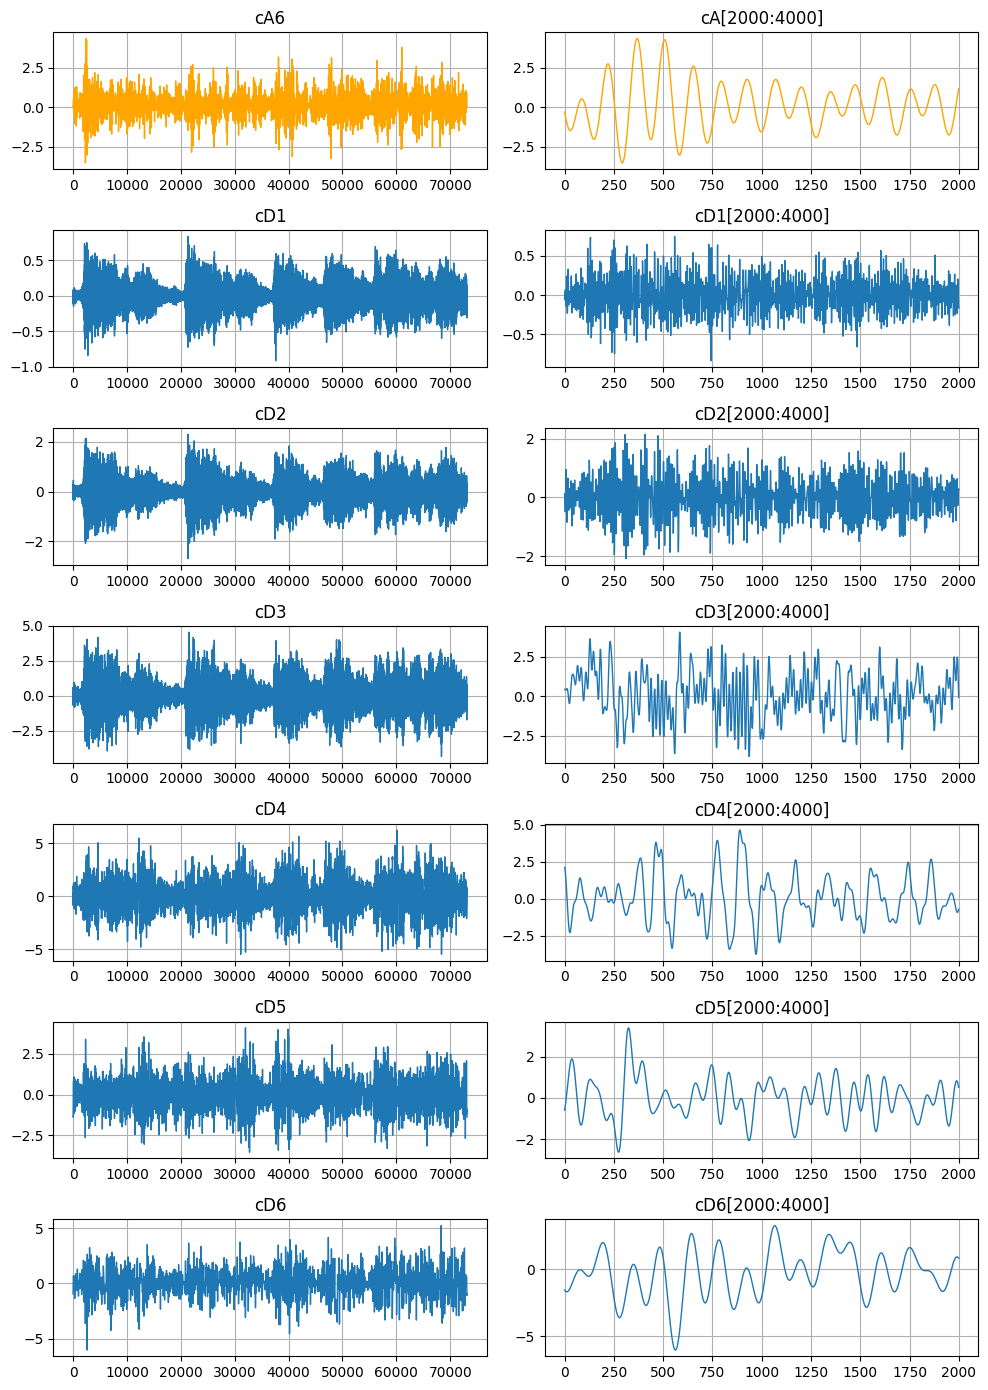

In [8]:
rows = level + 1
cols = 2
interval = slice(*zoomed_in_interval)

_, axs = plt.subplots(rows, cols, figsize=(10, 14))

# plot the approximation coefficients at the deepest level

cA_plot_color = 'orange'

axs[0, 0].plot(cA_at_level, linewidth=1, color=cA_plot_color)
axs[0, 0].set_title(f'cA{level}')
axs[0, 0].grid()
axs[0, 1].plot(cA_at_level[interval], linewidth=1, color=cA_plot_color)
axs[0, 1].set_title('cA' + f'[{zoomed_in_interval[0]}:{zoomed_in_interval[1]}]')
axs[0, 1].grid()

# plot the detail coefficients at each level in descending order
for i, coeff, title in zip([*range(1, rows)], cDs, [f'cD{i+1}' for i in range(level)]):
    axs[i, 0].plot(coeff, linewidth=1)
    axs[i, 0].set_title(title)
    axs[i, 0].grid()
    axs[i, 1].plot(coeff[interval], linewidth=1)
    axs[i, 1].set_title(title + f'[{zoomed_in_interval[0]}:{zoomed_in_interval[1]}]')
    axs[i, 1].grid()

plt.tight_layout()
plt.savefig(IMG_FOLDER / 'problem1-1-approximated-and-detailed-coeffs.pdf', format='pdf')    
plt.show()

### 1.2 Plot the reconstructed signal obtained using `db1` and `db2` wavelets

reconstructed_signal.shape: (73114,)


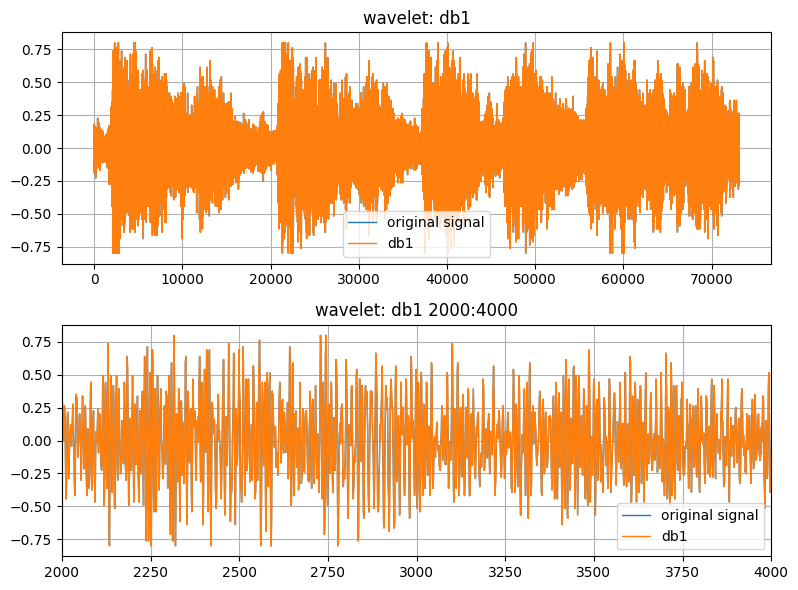

reconstructed_signal.shape: (73114,)


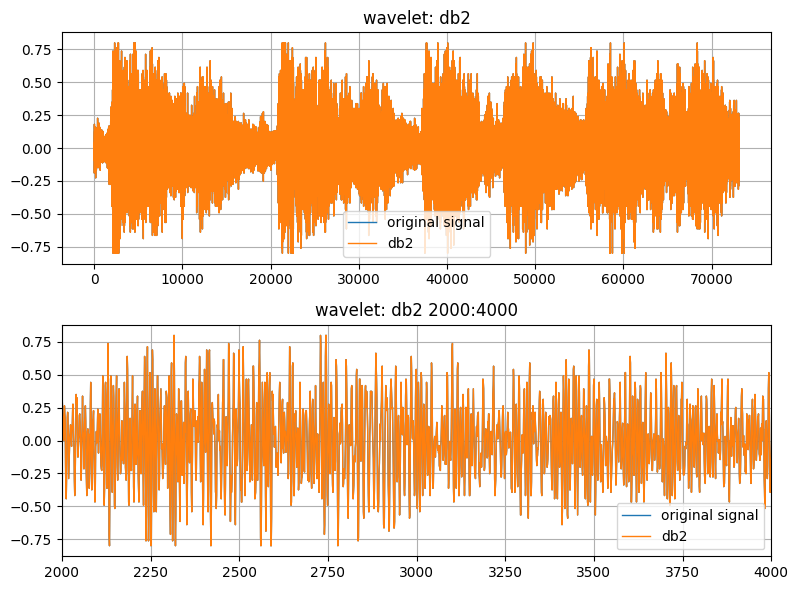

In [25]:
reconstructed_signals = {}

for i, wavelet in enumerate(['db1', 'db2']):
    coeffs = pywt.wavedec(y, wavelet, level=level)

    reconstructed_signal = pywt.waverec(coeffs, wavelet).squeeze()
    
    print(f'reconstructed_signal.shape: {reconstructed_signal.shape}')

    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
    ax1.plot(y, label='original signal', linewidth=1)
    ax1.plot(reconstructed_signal, label=wavelet, linewidth=1)
    ax1.set_title(f'wavelet: {wavelet}')
    ax1.legend()
    ax1.grid()

    ax2.plot(y, label='original signal', linewidth=1)
    ax2.plot(reconstructed_signal, label=wavelet, linewidth=1)
    ax2.set_title(f'wavelet: {wavelet} {zoomed_in_interval[0]}:{zoomed_in_interval[1]}')
    ax2.set_xlim(zoomed_in_interval)
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.savefig(IMG_FOLDER / f'problem1-2-reconstructed-signal-{wavelet}.pdf', format='pdf')
    plt.show()

    reconstructed_signals[wavelet] = reconstructed_signal

### 1.3 Hear the reconstructed signal obtained using `db1` and `db2` wavelets. Report on your findings.

In [26]:
for wavelet, reconstructed_signal in reconstructed_signals.items():
    file = f'reconstructed_signal_{wavelet}.wav'
    sp.io.wavfile.write(file, Fs, reconstructed_signal.astype(np.float32))

### FINDINGS
No audible difference between the two wavelets. The reconstructed signal is the same as the original signal.

In [ ]:
# play the temporary file with ffplay
!ffplay -nodisp -autoexit $file

In [ ]:
!mpv --no-video {file} # play the temporary wav file with mpv

### 1.4 Also, comment on the error obtained on the reconstructed signals for `db1` and `db2`.

In [31]:
def rmse(x: np.ndarray, y: np.ndarray) -> float:
    """RMSE between two signals"""
    assert x.shape == y.shape, f'x.shape: {x.shape}, y.shape: {y.shape}'
    return np.sqrt(np.mean((x - y)**2) / len(x))

for wavelet, reconstructed_signal in reconstructed_signals.items():
    if len(reconstructed_signal) > len(y):
        reconstructed_signal = reconstructed_signal[:len(y)]
    print(f'RMSE between the original signal and the reconstructed signal with {wavelet}: {rmse(y, reconstructed_signal):.3e}')

RMSE between the original signal and the reconstructed signal with db1: 3.142e-19
RMSE between the original signal and the reconstructed signal with db2: 2.216e-19


### FINDINGS
The error is the same for both wavelets. The error is 0.0.

---
# Problem 2

In [39]:
mu = 0.0
sigma = 3
# gaussian noise
noise = np.random.normal(mu, sigma, EEG.shape)
EEG_with_noise = EEG + noise

In [27]:
EEG.shape
# TODO: the problem says that the signal is an image, but it is actually a 1D signal

(2500, 1)

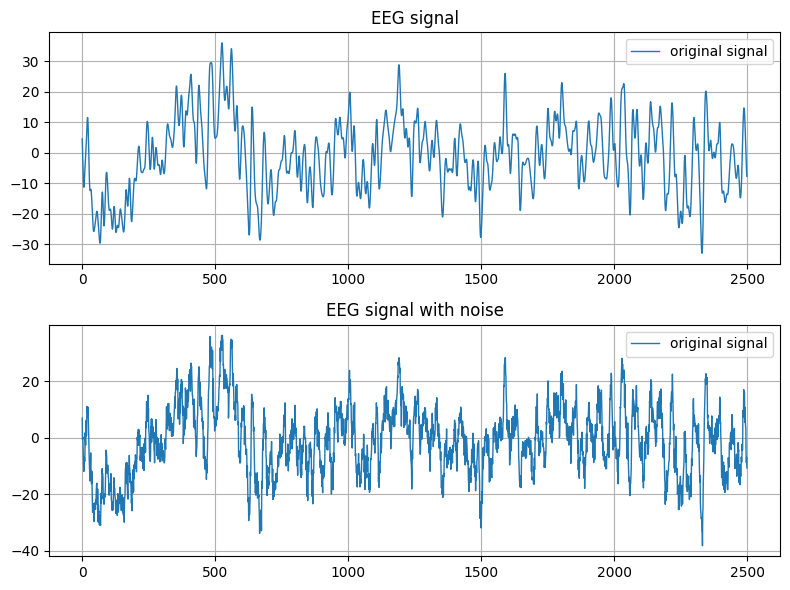

In [40]:
# visulaize the EEG signal with and without noise
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(EEG, label='original signal', linewidth=1)
ax1.set_title('EEG signal')
ax1.legend()
ax1.grid()

ax2.plot(EEG_with_noise, label='original signal', linewidth=1)
ax2.set_title('EEG signal with noise')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.savefig(IMG_FOLDER / 'problem2-1-EEG-signal-with-and-without-noise.pdf', format='pdf')
plt.show()


## 2.1 Compute signal to noise ratio (SNR).

In [41]:
def snr(x: np.ndarray, y: np.ndarray) -> float:
    """Signal-to-noise ratio between two signals"""
    assert x.shape == y.shape, f'x.shape: {x.shape}, y.shape: {y.shape}'
    return 10 * np.log10(np.mean(x**2) / np.mean((x - y)**2))

In [43]:
# SNR = snr(EEG, EEG_with_noise)
SNR = 10 * np.log10(np.mean(EEG**2) / np.mean(noise**2))
print(f'SNR: {SNR:.2f} dB')

SNR: 12.17 dB


## 2.2 Decompose the signal using wavedec (Haar, and db2).

In [46]:
level = 3

decompositions = {}

for wavelet in ['haar', 'db2']:
    coeffs = pywt.wavedec(EEG_with_noise, wavelet, level=level)
    decompositions[wavelet] = coeffs

## 2.3 Plot the subbands obtained using Haar and db2 decomposition.

In [ ]:
# refactor plotting code in 1.a and use it here

## 2.4 Observe the subbands and list your observations.

## 3.a Compute the SNR for different σ values and values of σ = {0.5, 1, 2, 4}

In [ ]:
level = 3

# what wavelet to use for denoising?
# dwt only does one level of decomposition
pywt.dwt(noisy_EEG, 'haar', level=level)


n = 0 # number of detail coefficients
sigma = 0 # estimate of the noise level

T = sigma * np.sqrt(2 * np.log(n)) # threshold
# set all detail coefficients smaller than T to zero
# arr[arr < T] = 0

## 3.b Plot the original, noisy, and denoised signal in anyone case.

## 3.c Evaluate the RMSE and comment on your interpretations for each case.